In [2]:
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install segmentation-models==1.0.1
!pip install efficientnet==1.1.1
!pip install opencv-python
!pip install patchify
!pip install scikit-learn
!pip install tqdm
!pip install pillow

In [3]:
!pip install pandas

  Using cached pandas-2.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.1-cp313-cp313-macosx_11_0_arm64.whl (10.7 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]


In [5]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.6 MB/s  0:00:03 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.5 MB/s  0:00:01 eta 0:00:01
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [7]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [10]:
!pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.31.1-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached numpy-2.3.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached charset_normalizer-3.4.2-cp313-cp313-macosx_10_13_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

In [11]:
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

In [25]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [21]:
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

In [2]:
def data_loader(folder_dir):
    image_dataset = []
    file_list = sorted(os.listdir(folder_dir))

    for images in file_list:
        image_path = os.path.join(folder_dir, images)
        image = cv2.imread(image_path, 1)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (128, 128))
            image = Image.fromarray(image)
            image = np.array(image)
            image_dataset.append(image)
        else:
            print(f"Warning: Could not load {image_path}")

    print(f"Loaded {len(image_dataset)} images from {folder_dir}")
    return image_dataset

In [15]:
def patched_data_load(folder_dir, patch_size, max_patches_per_image=4, sample_ratio=0.3):
    """
    Load and patch images with memory-efficient sampling

    Args:
        folder_dir: Directory containing images
        patch_size: Size of patches to extract
        max_patches_per_image: Maximum patches to extract per image
        sample_ratio: Fraction of total files to process (0.1 = 10%)
    """
    image_dataset = []
    files = sorted(os.listdir(folder_dir))

    # Calculate number of files to process based on dataset size
    total_files = len(files)
    if total_files <= 50:
        selected_files = files  # Use all files for small datasets
    elif total_files <= 500:
        n_files = int(total_files * sample_ratio)  # Use 30% for medium datasets
        selected_files = files[:n_files]
    else:
        n_files = min(150, int(total_files * 0.15))  # Cap at 150 files for large datasets
        selected_files = files[:n_files]

    print(f"Processing {len(selected_files)} out of {total_files} files")

    for images in tqdm(selected_files, desc=f"Processing {folder_dir}"):
        image_path = os.path.join(folder_dir, images)
        image = cv2.imread(image_path, 1)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Skip images smaller than patch size
            if image.shape[0] < patch_size or image.shape[1] < patch_size:
                continue

            image = Image.fromarray(image)
            image = np.array(image)

            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            # Limit patches per image and sample strategically
            patch_count = 0
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    if patch_count >= max_patches_per_image:
                        break

                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]

                    # Skip patches with too much background (optional quality filter)
                    if np.mean(single_patch_img) > 10:  # Avoid completely black patches
                        single_patch_img = cv2.resize(single_patch_img, (128, 128))
                        image_dataset.append(single_patch_img)
                        patch_count += 1

                if patch_count >= max_patches_per_image:
                    break
        else:
            print(f"Warning: Could not load {image_path}")

    print(f"Generated {len(image_dataset)} patches")
    return image_dataset

In [16]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape, dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]
    return label_seg

In [9]:
import os
import cv2
print("Loading image and mask datasets...")
image_dataset = data_loader("/Users/akshitsoni/Downloads/semantic_drone_dataset/training_set/images")
mask_dataset = data_loader("/Users/akshitsoni/Downloads/semantic_drone_dataset/training_set/gt/semantic/label_images")

Loading image and mask datasets...
Loaded 400 images from /Users/akshitsoni/Downloads/semantic_drone_dataset/training_set/images
Loaded 400 images from /Users/akshitsoni/Downloads/semantic_drone_dataset/training_set/gt/semantic/label_images


In [10]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [12]:
import random

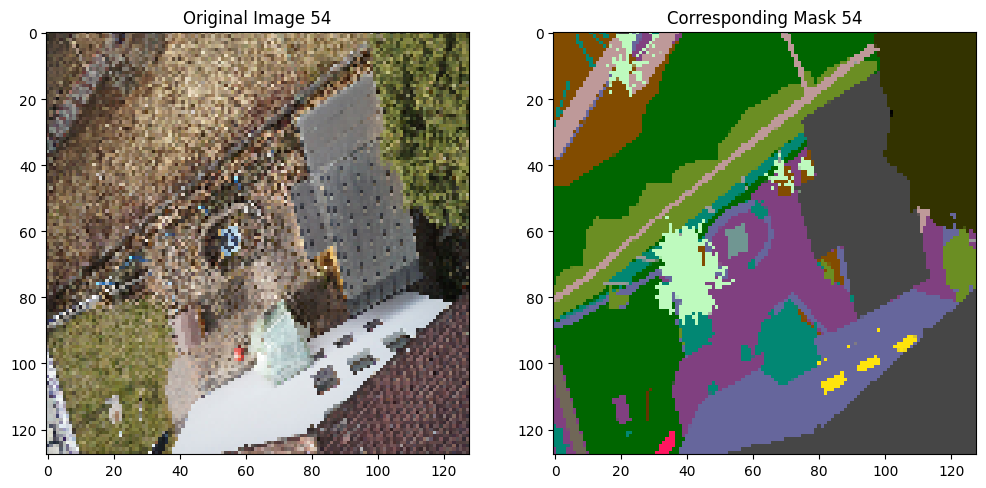

In [13]:
image_number = random.randint(0, len(mask_dataset)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(f'Original Image {image_number}')
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.title(f'Corresponding Mask {image_number}')
plt.imshow(mask_dataset[image_number])
plt.show()

In [14]:
mask_labels = pd.read_csv('/Users/akshitsoni/Downloads/semantic_drone_dataset/training_set/gt/semantic/class_dict.csv')
print("Class labels:")
print(mask_labels)

Class labels:
           name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0


In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels)
    labels.append(label)

In [18]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

print("Unique labels in dataset:", np.unique(labels))

Unique labels in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


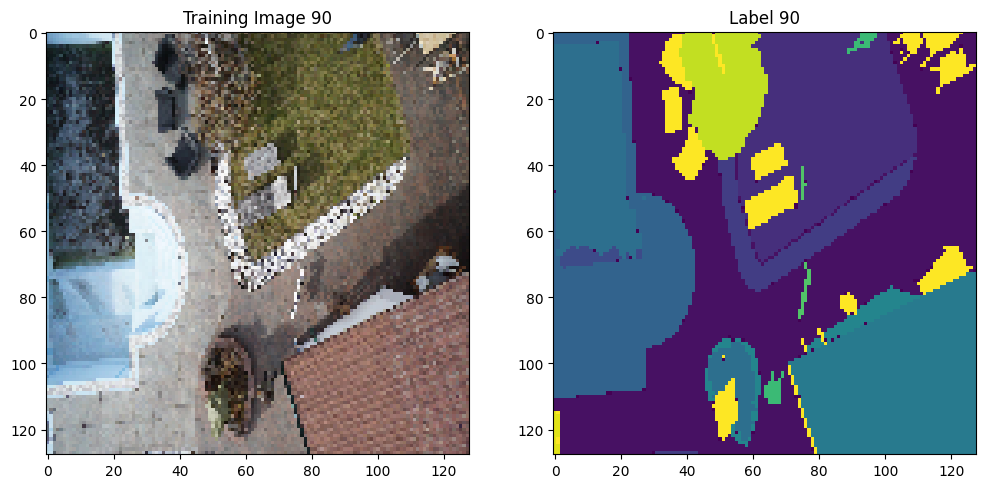

In [19]:
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(f'Training Image {image_number}')
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.title(f'Label {image_number}')
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [22]:
# One-hot encoding
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, labels_cat, test_size=0.20, random_state=42
)

In [26]:
# Using pretrained ResNet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)


In [27]:
# Preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [28]:
# Define original U-Net model with ResNet backbone
model_resnet_backbone = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    classes=n_classes,
    activation='softmax'
)

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 41s 0us/step


In [29]:
# Compile model
metrics = ['accuracy']
model_resnet_backbone.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

print("Model summary:")
model_resnet_backbone.summary()

Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,459,344 (93.30 MB)

 Trainable params: 24,441,994 (93.24 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [30]:
# Train the model
print("Starting training...")
history = model_resnet_backbone.fit(
    X_train_prepr,
    y_train,
    batch_size=16,
    epochs=100,
    verbose=1,
    validation_data=(X_test_prepr, y_test)
)

Starting training...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3482 - loss: 2.5047 - val_accuracy: 0.0642 - val_loss: 168.3262
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5715 - loss: 1.6394 - val_accuracy: 0.3794 - val_loss: 29.5451
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5966 - loss: 1.4732 - val_accuracy: 0.1852 - val_loss: 213.4875
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6239 - loss: 1.3519 - val_accuracy: 0.4108 - val_loss: 5.2755
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6473 - loss: 1.2631 - val_accuracy: 0.2680 - val_loss: 3.3910
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6488 - loss: 1.2483 - val_accuracy: 0.6128 - val_loss: 1.7915
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6786 - loss: 1.1144 - val_accuracy: 0.6604 - val_loss: 1.2957
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6728 - loss: 1.0963 

In [31]:
# Plot training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

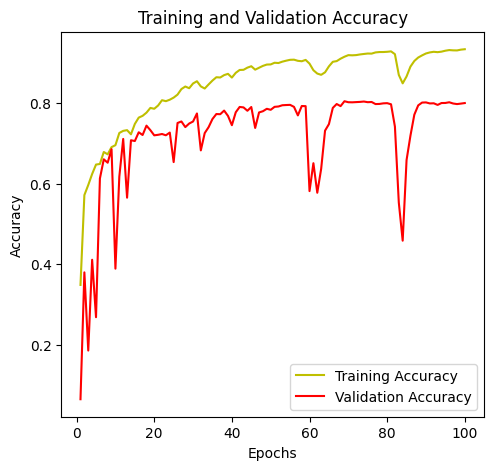

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

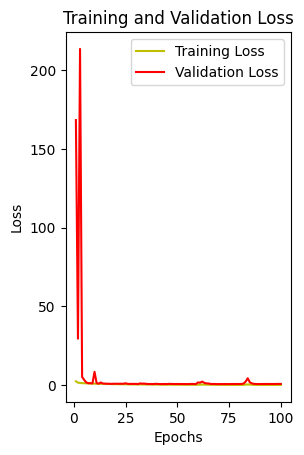

In [33]:

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
# Save model
model_resnet_backbone.save('resnet_backbone.h5')
print("Model saved as 'resnet_backbone.h5'")

Model saved as 'resnet_backbone.h5'


In [39]:
# Make predictions
y_pred = model_resnet_backbone.predict(X_test_prepr)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step


In [42]:
# Visualize results
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = model_resnet_backbone.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0,:,:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


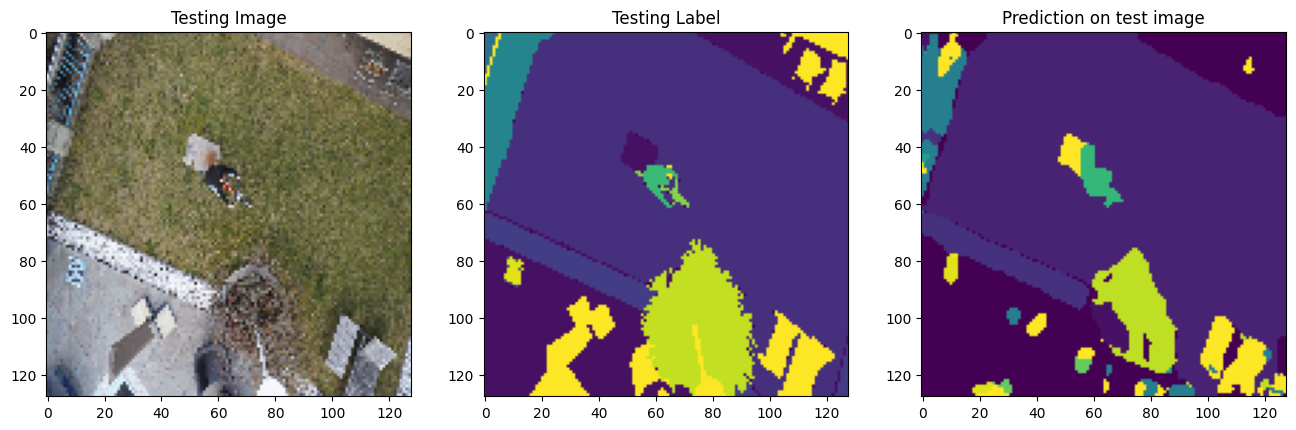

In [43]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [38]:
print("✓ METHOD complete using original segmentation-models library!")
print(f"✓ Classes detected: {n_classes}")

✓ METHOD complete using original segmentation-models library!
✓ Classes detected: 23
